### 06/25/23
### Joshua Edelstein


# Pneumonia Analysis
## Overview
According to the World Health Organization (WHO), pneumonia kills around two million children under five years old every year and therefore is consistently estimated as the single leading cause of childhood mortality (Rudan et al., 2008). The WHO reports that 95% of new cases of pneumonia occur in developing countries, particularly in Southeast Asia and Africa. 
Bacterial and viral pathogens are the two leading causes of pneumonia (Mcluckie, 2009) yet require very different forms of management. Bacterial pneumonia requires urgent antibiotic treatment, while viral pneumonia is treated with supportive care. Therefore, accurate and timely diagnosis is imperative. A key part of the diagnosis is based on chest X-rays as they are routinely obtained and can help differentiate between the different types of pneumonia. However, the areas that struggle with childhoold pneumonia are lacking in doctors to interpret the xrays.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

[^1]: [Data from Cell.com](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

## Business Understanding 
Given the issue at hand, there are 2 possible approaches. The first is to have many qualified doctors on hand in these countries to read all the xrays that are coming in and suggest a course of treatment. However, being that there are so many xrays this can be extremely time consuming, costly, and we may not have the requisite amount of doctors vonlunteering to go. 
Instead a leading doctor on the ground in Africa, Dr. Xavier Radiance, suggested creating a model that identifies whether a patient has pneumonia in general or not. If the model makes a positive prediction for pneumonia the xray will be passed over to a doctor to read whether the patient indeed has pneumonia and if they do, whether it is bacterial or viral. This method will cut down on the number of doctors required as they no longer have to read all the xrays; rather only the xrays that have been predicted positive. Our goal is to create the model for use by the doctors in these countries.
It's important to think about whether false positives or false negatives are worse in this case. A false positive means that the model predicts that the xray has pneumonia when it really doesn't. This may lead to providing treatment for a patient when it is not necessary. While a false negative means that the model predicts that the patient doesn't have pneumonia when he really does. This would mean not giving a patient treatment when they do need it. Being that we have a safety net of doctors reading the positive xrays, we don't need to be concerned for false positives nearly as much as false negatives, as the doctors will read all the xrays that are predicted positive. As such we will want to have a recall as high as possible so we catch all the patients with pneumonia.

<div>
<img src="images/xray.jpg", width = 800, height = 400/>
</div>

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/x-ray?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Data Understanding
Content
This public dataset of 5,863 X-Ray images is provided by Mendeley data. The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). The  pneumonia are a labeled mix of bacterial or viral. 

The X-ray images were taken in 2017 from cohorts of pediatric patients between one to five years old from the Guangzhou Women and Children’s Medical Center, Guangzhou. All chest xrays were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by three expert physicians.<a name="cite_ref-1"></a>[<sup>[2]</sup>](#cite_note-2)


[^2]: [Data from Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2)


Let's do some EDA on the data to find our more about it.

We'll begin by importing all the packages we may need. Then we will load up the data.

In [1]:
import pandas as pd       

import numpy as np
from numpy.random import seed
seed(42)

import matplotlib as mat
import matplotlib.pyplot as plt    
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100


import random
import os

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.random import set_seed
set_seed(42)
from tensorflow import keras
from keras import layers, Model, optimizers, regularizers, initializers, applications
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Input, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

import skimage
from skimage import io, transform
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from lime import lime_image


import glob
import cv2


import warnings
warnings.filterwarnings('ignore')

We'll first define the paths to the folders and then specific file paths for normal patients and those with pneumonia

In [2]:
# Define the main path to your data folder
main_path = "data/xray"

# Define the paths to the train, test, and validation folders
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")
val_path = os.path.join(main_path, "val")

# Get the file paths for the normal and pneumonia images in the train folder
train_normal = glob.glob(os.path.join(train_path, "NORMAL_train", "*.jpeg"))
train_pneumonia = glob.glob(os.path.join(train_path, "PNEUMONIA_train", "*.jpeg"))

# Get the file paths for the normal and pneumonia images in the test folder
test_normal = glob.glob(os.path.join(test_path, "NORMAL_test", "*.jpeg"))
test_pneumonia = glob.glob(os.path.join(test_path, "PNEUMONIA_test", "*.jpeg"))

# Get the file paths for the normal and pneumonia images in the validation folder
val_normal = glob.glob(os.path.join(val_path, "NORMAL_val", "*.jpeg"))
val_pneumonia = glob.glob(os.path.join(val_path, "PNEUMONIA_val", "*.jpeg"))

Now we can move on to creating our dataframe

In [3]:
# Create a list of file paths for the training set
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

# Create the training dataframe with class labels and image paths
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns=['class'])
df_train['image'] = [x for x in train_list]

# Create a list of file paths for the test set
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

# Create the test dataframe with class labels and image paths
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns=['class'])
df_test['image'] = [x for x in test_list]

# Create a list of file paths for the validation set
val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

# Create the validation dataframe with class labels and image paths
df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns=['class'])
df_val['image'] = [x for x in val_list]

In [4]:
#print df_train to make sure it worked
df_train

,class,image
0,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-0927-0001.jpeg
1,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-1056-0001.jpeg
2,Normal,data/xray/train/NORMAL_train/IM-0427-0001.jpeg
3,Normal,data/xray/train/NORMAL_train/NORMAL2-IM-1260-0001.jpeg
4,Normal,data/xray/train/NORMAL_train/IM-0656-0001-0001.jpeg
...,...,...
5211,Pneumonia,data/xray/train/PNEUMONIA_train/person142_virus_288.jpeg
5212,Pneumonia,data/xray/train/PNEUMONIA_train/person364_bacteria_1659.jpeg
5213,Pneumonia,data/xray/train/PNEUMONIA_train/person1323_virus_2283.jpeg
5214,Pneumonia,data/xray/train/PNEUMONIA_train/person772_virus_1401.jpeg


Let's pull up the length of each df, to make sure that each is large enough to validate our data. 

In [5]:
length_train = len(df_train)
length_test = len(df_test)
length_val = len(df_val)

print("Length of df_train:", length_train)
print("Length of df_test:", length_test)
print("Length of df_val:", length_val)

Length of df_train: 5216
Length of df_test: 624
Length of df_val: 16


Being that the validation set is so small, it is possible that we may get good results on the validation by chance. Therefore let's create an additional validation set from the training set. We will use the new val_df that we create as our new validation set when we train our model. Then we will evaluate our model on the testing set.

In [6]:
# create a seed for reproducibility
SEED = 42

# split the df_train into a new train_df and val_df. Use 18% of the data for the val df
train_df, val_df = train_test_split(df_train, test_size = 0.18, 
                                    random_state = SEED, stratify = df_train['class'])

#confirm that it worked
print(len(train_df))
print(len(val_df))

4277
939


We will now inspect each subset of the data to see how they compare with eachother. We'll start by pulling up bar graphs of each dataset on it's own respective axis to see what the distribution looks like within each group

In [7]:
def plot_class_distribution(dataframe, title, ylim):
    # Create a new figure with the specified size
    plt.figure(figsize=(6, 4))

    # Define the class labels and get the corresponding counts from the dataframe
    class_labels = ['Pneumonia', 'Normal']
    class_counts = dataframe['class'].value_counts()

    # Define colors for the bars
    colors = ['skyblue', 'salmon']

    # Create the bar plot with the specified colors
    plt.bar(class_labels, class_counts, color=colors)

    # Set the title
    plt.title(title)

    # Set the x-label and y-label
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('# of Samples', fontsize=12)

    # Set the y-axis limits
    plt.ylim(0, ylim)

    # Set the x-axis tick labels
    plt.xticks(fontsize=11)

    # Add count labels above each bar
    for i, count in enumerate(class_counts):
        plt.text(i, count + 1, str(count), ha='center', fontsize=13)

    # Display the plot
    plt.show()

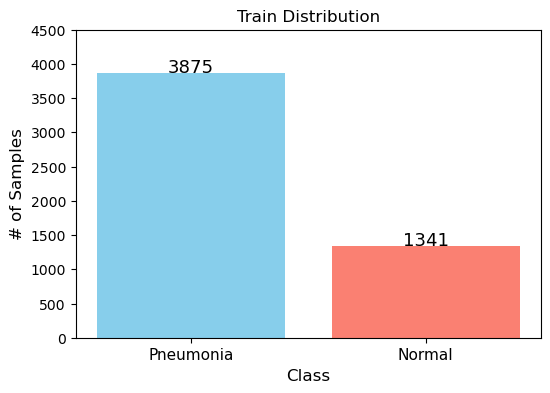

In [8]:
plot_class_distribution(df_train, 'Train Distribution', 4500)

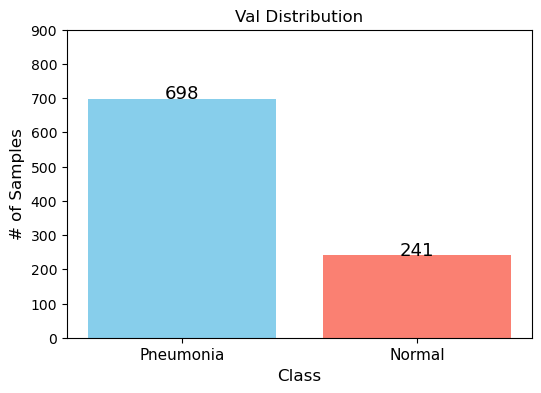

In [9]:
plot_class_distribution(val_df, 'Val Distribution', 900)

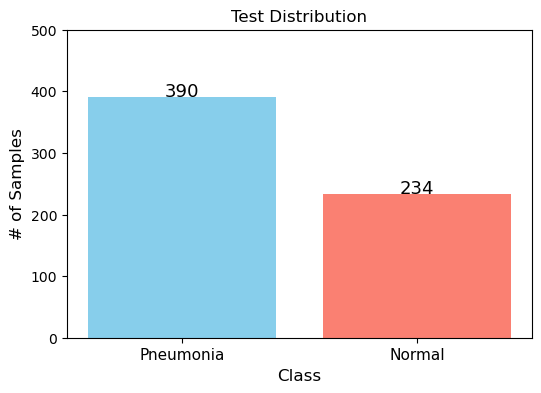

In [10]:
plot_class_distribution(df_test, 'Test Distribution', 500)

Now let's create a table that summarizes our findings

In [11]:
# Create a list of dataset names
dataset_names = ['Train', 'Test', 'Validation']

# Create a list of corresponding dataframes
dataframes = [train_df, df_test, val_df]

# Create an empty list to store the balance information
balance_info = []

# Iterate over each dataset and calculate the balance
for dataset_name, df in zip(dataset_names, dataframes):
    normal_count = df[df['class'] == 'Normal'].shape[0]
    pneumonia_count = df[df['class'] == 'Pneumonia'].shape[0]
    total_samples = normal_count + pneumonia_count
    pneumonia_percent = round((pneumonia_count / total_samples) * 100)
    balance_info.append({'Dataset': dataset_name, 'Normal': normal_count, 'Pneumonia': pneumonia_count, 'Percent with Pneumonia': pneumonia_percent})

# Create the balance table
balance_table = pd.DataFrame(balance_info)

# Print the balance table
print(balance_table)

      Dataset  Normal  Pneumonia  Percent with Pneumonia
0       Train    1100       3177                      74
1        Test     234        390                      62
2  Validation     241        698                      74


We say that the main dataset we will be modeling off is unbalanced with a ratio of roughly 3:1 with Pneumonia, as is the validation set. While the test set is only slightly imbalanced. Using the testing set to test the model will allow us to make sure our model works on different ratios of images.

### Viewing the Images
Before we move on to preparing our data let's take a look some samples of Normal xrays as well as Pneumonia xrays to see if there is anything interesting there.

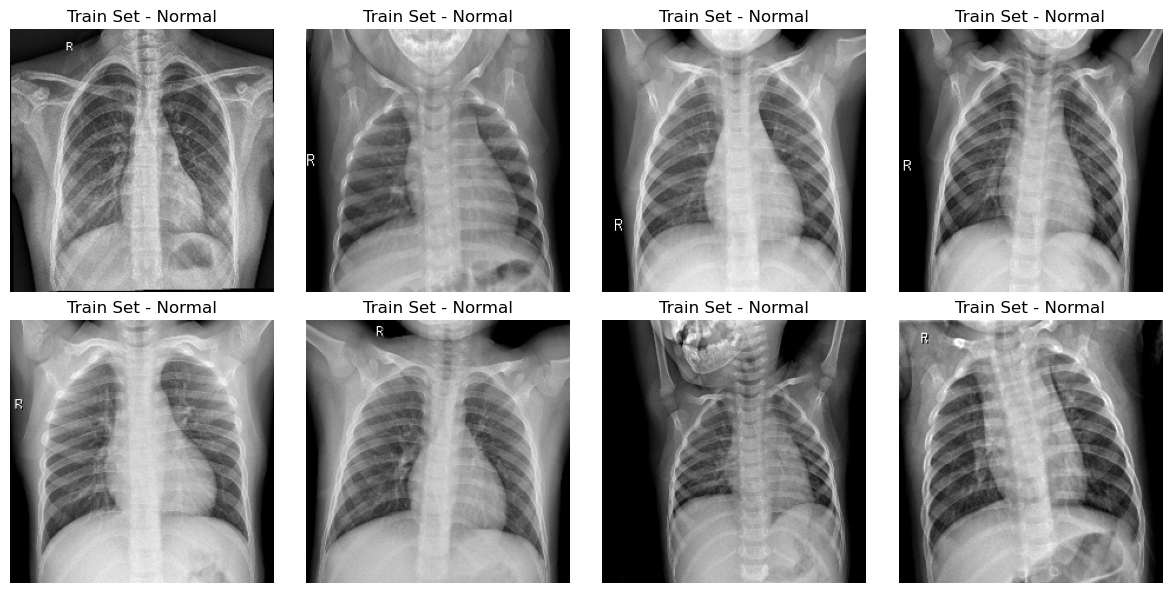

In [12]:
# Set the desired image size
IMG_SIZE = 224

# Create a new figure with the specified size and subplots arrangement
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Iterate over the train_normal images and axes to display the images
for i, (image_path, ax) in enumerate(zip(train_normal[:8], axes.flatten())):
    # Read and resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Display the image in the subplot
    ax.imshow(img)

    # Turn off axis labels
    ax.axis('off')

    # Set the title of the subplot
    ax.set_title('Train Set - Normal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

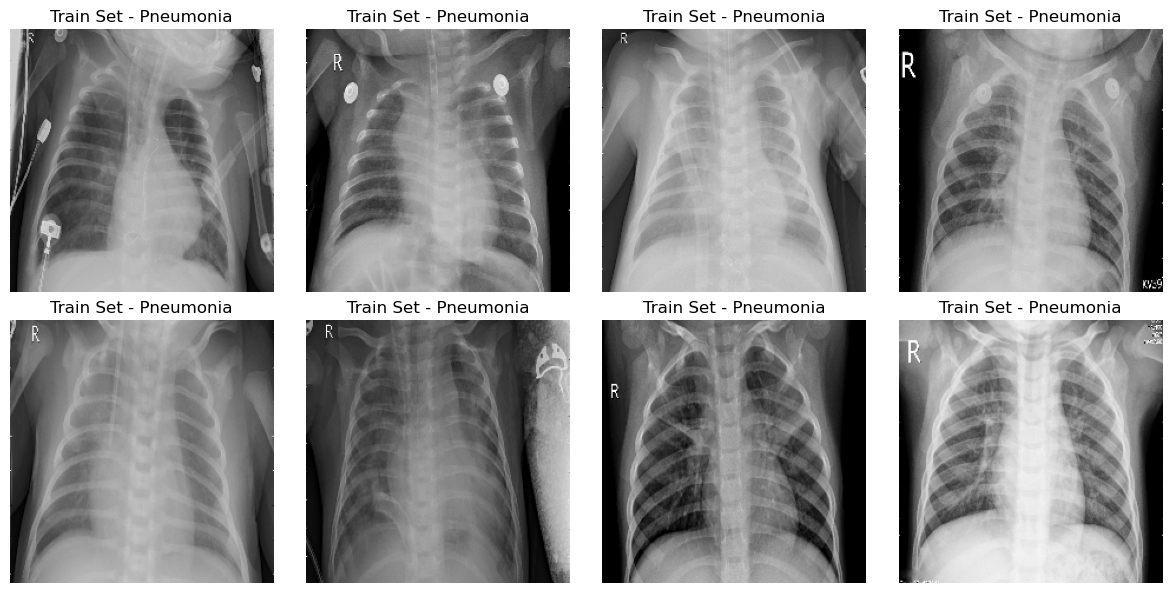

In [13]:
# Create a new figure with the specified size and subplots arrangement
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Iterate over the train_normal images and axes to display the images
for i, (image_path, ax) in enumerate(zip(train_pneumonia[:8], axes.flatten())):
    # Read and resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Display the image in the subplot
    ax.imshow(img)

    # Turn off axis labels
    ax.axis('off')

    # Set the title of the subplot
    ax.set_title('Train Set - Pneumonia')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Obviously, we are not experts but it seems that the Normal patient xrays are a bit cleaner. Let's move on to preprocessing
## Modeling

For our Baseline model we'll create a very basic model. The first step to doing this is preparing the data for our model. We'll reload the data in a different form for our baseline model, using the ImageDataGenerator and flow_from_directory

In [14]:
#rename the data path
train_data_dir = 'data/xray/train'
test_data_dir = 'data/xray/test'
val_data_dir ='data/xray/val'

# Get all the data in the directory data/train (5216 images), and reshape them
print('Train Images:')
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

print('Test Images:')
# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=624)
print('Val Images:')

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Train Images:
Found 5216 images belonging to 2 classes.
Test Images:
Found 624 images belonging to 2 classes.
Val Images:


In [15]:
# Perform train-test split on the train set
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels, 
                                                                      test_size=0.18, 
                                                                      random_state=SEED)

In [16]:
# Print the shapes of the new datasets
print("Train length:", len(train_images))
print("Val length:", len(val_images))

Train length: 4277
Val length: 939


Now we need to reshape both the images as well as are labels and we are ready to begin modeling.

In [17]:
# Reshape the train, test and val images 
train_img_unrow = train_images.reshape(-1, 64*64*3)
test_img_unrow = test_images.reshape(-1, 64*64*3)
val_img_unrow = val_images.reshape(-1, 64*64*3)

#create new datasets that are transposed versions of the label dataset
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]
val_labels_final = val_labels.T[[1]]

#Transpose again to get the correct shape
train_labels_final = train_labels_final.T
test_labels_final = test_labels_final.T
val_labels_final = val_labels_final.T

### Baseline Model
We'll begin by setting our model as a Sequential model, this means that one layer will build on the next

In [18]:
#set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Create the baseline model
baseline_model = Sequential()

Metal device set to: Apple M1 Pro


2023-07-03 14:36:29.297635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-03 14:36:29.297776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Add layers
Now that we have initialized a network we will add layers to the network, which include the number of layers, as well as the activation function.

The Dense() class indicates that this layer will be fully connected. 

For our `baseline_model` we'll use one hidden layers with 64 unitswith a 'relu' activation function. Also, since this is the first hidden layer, we'll pass in input_shape=(12288,). Since we are dealing with a multiclass problem (classifying the xrays into 2), we'll use a 'softmax' classifier in order to output 2 class probabilities per case

In [19]:
#add the hidden layer to the NN with 64 units, and an activation of 'relu'
baseline_model.add(Dense(64, activation='relu', input_shape=(12288,)))

#add the output layer with 1 units and an activation of sigmoid
baseline_model.add(Dense(1, activation='sigmoid'))  # Output layer with 2 unit for binary classification

Now, let's move on to compiling our model. We'll use `'SGD'` as our optimizer for our baseline model. For our loss we'll use binary crossentropy since this is a binary classification problem. 

In [20]:
#set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Compile the model 
baseline_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Before we run our model lets pull up some summary statistics

In [21]:
#pull up summary statistics
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                786496    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 786,561
Trainable params: 786,561
Non-trainable params: 0
_________________________________________________________________


We see that our model has 786,754 trainable parameters, and this is only our baseline model. 
Now let's move on to actually fitting and running our model.

Before we do that we'll create an early stop function, which stops the model if there is no improvement in the validation set loss. In our case, we need to minimize false positives, because every false positive means we would assume patients don't have pneumonia when they really do. This would lead to lack of treatment, which could lead to possible sickness or even worse. To do this we will monitor the loss in the testing set. Although this is not directly linked to the recall, if the model is a better model overall then most likely the recall will be higher. Later on when we get better models, we will focus closer on recall. In our early stopping parameter, we'll allow the model to run 5 epochs with no improvement before it stops the model.

We'll start out with only 10 epochs and a batch size of 64. We'll also use our test set to test our model

In [22]:
# Define the callbacks, continue training for 5 epochs before stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [23]:
#set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Train the model
results_baseline = baseline_model.fit(train_img_unrow, train_labels_final, epochs=10, 
                                      batch_size=64, callbacks=early_stopping,
                                      validation_data=(val_img_unrow, val_labels_final))

Epoch 1/10


2023-07-03 14:36:29.548108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-03 14:36:29.674977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 1s 12ms/step - loss: 4792.4302 - accuracy: 0.7337 - val_loss: 0.6653 - val_accuracy: 0.7220
Epoch 2/10
 1/67 [..............................] - ETA: 0s - loss: 0.6530 - accuracy: 0.8125

2023-07-03 14:36:30.457951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 1s 8ms/step - loss: 0.6484 - accuracy: 0.7475 - val_loss: 0.6426 - val_accuracy: 0.7220
Epoch 3/10
67/67 [==============================] - 1s 8ms/step - loss: 0.6261 - accuracy: 0.7475 - val_loss: 0.6267 - val_accuracy: 0.7220
Epoch 4/10
67/67 [==============================] - 1s 8ms/step - loss: 0.6101 - accuracy: 0.7475 - val_loss: 0.6156 - val_accuracy: 0.7220
Epoch 5/10
67/67 [==============================] - 1s 8ms/step - loss: 0.5984 - accuracy: 0.7475 - val_loss: 0.6078 - val_accuracy: 0.7220
Epoch 6/10
67/67 [==============================] - 1s 8ms/step - loss: 0.5899 - accuracy: 0.7475 - val_loss: 0.6024 - val_accuracy: 0.7220
Epoch 7/10
67/67 [==============================] - 1s 8ms/step - loss: 0.5837 - accuracy: 0.7475 - val_loss: 0.5986 - val_accuracy: 0.7220
Epoch 8/10
67/67 [==============================] - 1s 8ms/step - loss: 0.5791 - accuracy: 0.7475 - val_loss: 0.5959 - val_accuracy: 0.7220
Epoch 9/10
67/67 [=============

Now, let's create a function that takes in our results and plots how they did in terms of accuracy and loss on both the training set as well as the validation set

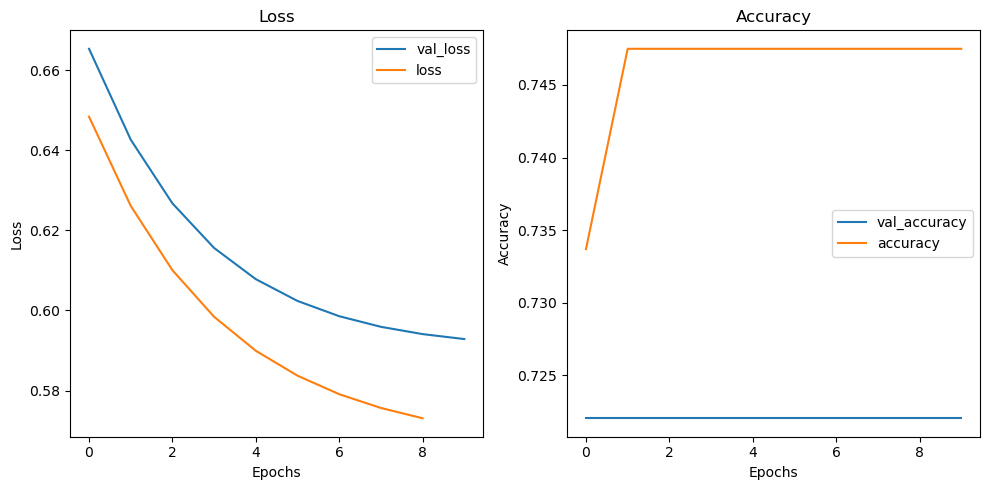

In [24]:
def visualize_training_results(results):
    # Set the history
    history = results.history

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the validation set loss below 100 followed by the training set loss below 1000
    axes[0].plot([loss for loss in history['val_loss'] if loss < 1000])
    axes[0].plot([loss for loss in history['loss'] if loss < 1000])
    axes[0].legend(['val_loss', 'loss'])
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')

    # Plot the accuracy for both the validation and training set
    axes[1].plot(history['val_accuracy'])
    axes[1].plot(history['accuracy'])
    axes[1].legend(['val_accuracy', 'accuracy'])
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


visualize_training_results(results_baseline)

Finally, we'll evaluate our model on our testing set.

In [25]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

# Evaluate the model on the test data
test_loss, test_accuracy = baseline_model.evaluate(test_img_unrow, test_labels_final)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 0s 6ms/step - loss: 0.6719 - accuracy: 0.6250
Test Loss: 0.6718563437461853
Test Accuracy: 0.625


2023-07-03 14:36:35.656143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Let's pull up a classification report to see how we did.

In [26]:
# Get predictions for the testing set
test_predictions = baseline_model.predict(test_img_unrow)
test_predictions = (test_predictions > 0.5)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(test_labels_final, test_predictions)
print(report)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       234
         1.0       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



2023-07-03 14:36:35.912160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Being that the loss and accuracy remained roughly the same for both sets over the course of our model, we can say that this isn't a great model. Our loss for the training set ended up being around .6, for both the training and validation set. Additionally, our accuracy for both the training and validation set was around 73%. However, the model performed much worse on the testing set with a loss of .67 and accuracy of 63%. Our model stopped early as there was no improvement. Although, there wasn't that much overfitting, the model didn't score well. However, most importantly the precision and accuracy are the same as the percent of xrays with pneumonia in the testing set. Additionally, the recall is 100%, it seems as though our model is just predicting that every single case as pneumonia. As such let's move on to a far more complex model.

## Convoluted Neural Network(CNN)
To prepare the images for our models, we utilize data generators from keras. These generators allow us to perform various preprocessing tasks which include data augmentation.

We will rescale the pixel values of the training set and introduce random transformations to augment the data. We will rescale the values for the test set, but will not perform any transformations on them. 

Now, we will use our data generators

In [27]:
BATCH = 32  # Batch size for training
# Define the train and validation data generators
train_datagen = ImageDataGenerator(
    rescale=1/255.,                  # Rescale pixel values to range [0, 1]
    zoom_range=0.1,                  # Randomly zoom the images by 10%
    #rotation_range=0.1,              # Randomly rotate the images by 10 degrees
    width_shift_range=0.1,           # Randomly shift the width of the images by 10%
    height_shift_range=0.1           # Randomly shift the height of the images by 10%
)

val_datagen = ImageDataGenerator(
    rescale=1/255.                    # Rescale pixel values to range [0, 1]
)

# Create the training data generator
ds_train = train_datagen.flow_from_dataframe(
    train_df,                        # DataFrame containing the training data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=BATCH,                 # Number of images per batch
    seed=SEED                         # Seed for reproducibility
)

# Create the validation data generator
ds_val = val_datagen.flow_from_dataframe(
    val_df,                          # DataFrame containing the validation data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=BATCH,                 # Number of images per batch
    seed=SEED                         # Seed for reproducibility
)

# Create the test data generator
ds_test = val_datagen.flow_from_dataframe(
    df_test,                         # DataFrame containing the test data
    x_col='image',                   # Column name for the image file paths
    y_col='class',                   # Column name for the image class labels
    target_size=(IMG_SIZE, IMG_SIZE), # Resize the images to the specified size
    class_mode='binary',             # The classification task is binary
    batch_size=1,                     # Each batch contains a single image
    shuffle=False                     # Do not shuffle the test images
)

Found 4277 validated image filenames belonging to 2 classes.
Found 939 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### CNN

Now let's create our first CNN. Before doing so we'll create an early stop function and a plateau function. The early stop will tell the model to stop if the model is no longer improving in a certain area. As stated earlier the area we will be monitoring is loss on the validation set, because the better the model is overall, the higher the recall will be. We will allow the model to run 5 epochs with no improvement before stopping. Additionally, if the change is so minute, we don't want to consider that as a decrease in loss. As such, we will set the minimum value of change that needs to be reached, as .0000001. Lastly we will add a parameter that tells the model to use the best weights found for the final model, and not just the last weights.

In [28]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',             # Metric to monitor for early stopping
    patience=5,                      # Number of epochs with no improvement before stopping
    min_delta=1e-7,                  # Minimum change in the monitored metric to be considered an improvement
    restore_best_weights=True        # Restore the weights from the epoch with the best monitored metric
)

Additionally, we will also use the `ReduceLROnPlateau` function which reduces the learning rate while the model is training when the monitored metric(`val_loss`) is no longer improving. The learning rate controls the step size of the model or how quickly the model adjusts itself based on the training data. If the `val_loss` has not improved within 2 epochs, we will reduce the learning rate by .2, and run the new learning rate immediately. Again, we will make sure that there is a change of atleast .0000001, and create a message statement when the learning rate is reduced

In [29]:
# Define the ReduceLROnPlateau callback
plateau = ReduceLROnPlateau(
    monitor='val_loss',              # Metric to monitor for reducing learning rate
    factor=0.2,                      # Factor by which the learning rate will be reduced
    patience=2,                      # Number of epochs with no improvement before reducing learning rate
    min_delt=1e-7,                   # Minimum change in the monitored metric to be considered an improvement
    cooldown=0,                      # Number of epochs to wait after reducing learning rate before resuming normal operation
    verbose=1                        # Verbosity mode (0: quiet, 1: update messages)
)

Now we will create our model. We'll create a sequential model where one layer builds off the next. We'll have 5 parts to our model all of which besides the output layer use a relu activation function. 
- First an input layer with Batch Normalization, Conv2D, MaxPool2D and Dropout. The Batch Normalization, normalizes the data to improve training speed and stability. Then the Conv2D uses convolution which means it slides a filter over the data to extract features. Then the MaxPool2D works on the Conv2D and helps retain the important features and discard the less important ones. Dropout will then set a percentage of the inputs from the training data to 0, to make sure that the model doesn't overfit. 
- The next two parts are hidden and will be basically the same as the first but with different numbers of filters
- Then we will have another hidden layer that will flatten the data into a 1D vector, followed by a fully connected Dense layer, and then we'll again use dropout.
- Finally our output layer will consist of a fully connected layer with a sigmoid output and 1 unit, as this is a binary classification problem

In [30]:
def create_model():
    #set seed
    tf.random.set_seed(42)
    np.random.seed(42)
    
    #Input shape = [width, height, color channels]
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Apply a 2D conv layer with 16 filters and 3x3 kernel size as the input layer
    x = Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = BatchNormalization()(x)# Apply batch normalization
    x = Activation('relu')(x)# Apply ReLU activation function
    x = MaxPool2D()(x)# Apply 2D max pooling
    x = Dropout(0.2)(x)# Apply dropout with a rate of 0.2

    # First hidden layer is the same as the input layer just with 32 filters
    x = Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.2)(x)
    
    # Same as prev layer just with 2 2D layers, each with 64 filters
    x = Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D()(x)
    x = Dropout(0.4)(x)

    # This layer will process the output of the conv layers we will Flatter the tensors 
    # and then create a fully connected layer with 64 units and a dropout of .5.
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer with sigmoid activation and 1 unit, as this is a binary classifier
    output = Dense(1, activation='sigmoid')(x)
    
    #create model using inputs and output
    model = Model(inputs=[inputs], outputs=output)
    
    return model

In [31]:
# Set the random seed
np.random.seed(42)

# Clear the Keras session to release memory and resources
keras.backend.clear_session()

#create model
cnn1_model = create_model()

Now, we'll compile our model using binary crossentropy as we have a binary predictor, and an adam optimizer with a learning rate of .00003, and our metric will be binary accuracy. Then we will pull up the summary statistics

In [32]:
# Compile model
cnn1_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=3e-5),
              metrics='binary_accuracy')

# get model summary
cnn1_model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

Finally, We will fit our model and see how it does

In [33]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)
    
# Train the model, using out set BATCH, and 50 epochs
results2 = cnn1_model.fit(ds_train,  
                    batch_size=BATCH, epochs=50,  
                    validation_data=ds_val,  # Validate model with validation set
                    callbacks=[early_stopping, plateau], #use early_stopping and plateau
                    steps_per_epoch=(len(train_df) / BATCH), # Set steps per epoch by dividing training size by batch size
                    validation_steps=(len(val_df) / BATCH)  # Same for validation step size
                    )

Epoch 1/50


2023-07-03 14:36:36.847370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: 0s - loss: 0.4869 - binary_accuracy: 0.7809

2023-07-03 14:38:23.819458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 112s 839ms/step - loss: 0.4869 - binary_accuracy: 0.7809 - val_loss: 0.7222 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 2/50
133/133 [==============================] - 56s 418ms/step - loss: 0.3037 - binary_accuracy: 0.8705 - val_loss: 0.9445 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 3/50
134/133 [==============================] - ETA: 0s - loss: 0.2340 - binary_accuracy: 0.9039
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
133/133 [==============================] - 57s 426ms/step - loss: 0.2340 - binary_accuracy: 0.9039 - val_loss: 1.0096 - val_binary_accuracy: 0.7433 - lr: 3.0000e-05
Epoch 4/50
133/133 [==============================] - 57s 425ms/step - loss: 0.1918 - binary_accuracy: 0.9242 - val_loss: 0.7976 - val_binary_accuracy: 0.7433 - lr: 6.0000e-06
Epoch 5/50
133/133 [==============================] - 56s 422ms/step - loss: 0.1765 - binary_accuracy: 0.9299 - val_loss: 0.3549 - val_bi

Let's pull up some summary statistics to see how our model did on our training and validation set

In [34]:
#evaluate the model on the validation set and pull up the loss and accuracy
score = cnn1_model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.12499451637268066
Val accuracy: 0.9595314264297485


In [35]:
def plot_learning_curve_loss(history):
    
    # Set plot size
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Create line plots
    sns.lineplot(x=history.epoch, y=history.history['loss'], color='blue')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='salmon')
    
    # Set title, x-axis, and y-axis labels
    ax.set_title('Learning Curve (Loss)')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    
    # Set y-axis limit
    ax.set_ylim(0, 0.5)
    
    # Set colors for legend
    line1 = mat.lines.Line2D([], [], color='blue', label='train')
    line2 = mat.lines.Line2D([], [], color='salmon', label='val')
    ax.legend(handles=[line1, line2], loc='best')
    
    # Show the plot
    plt.show()

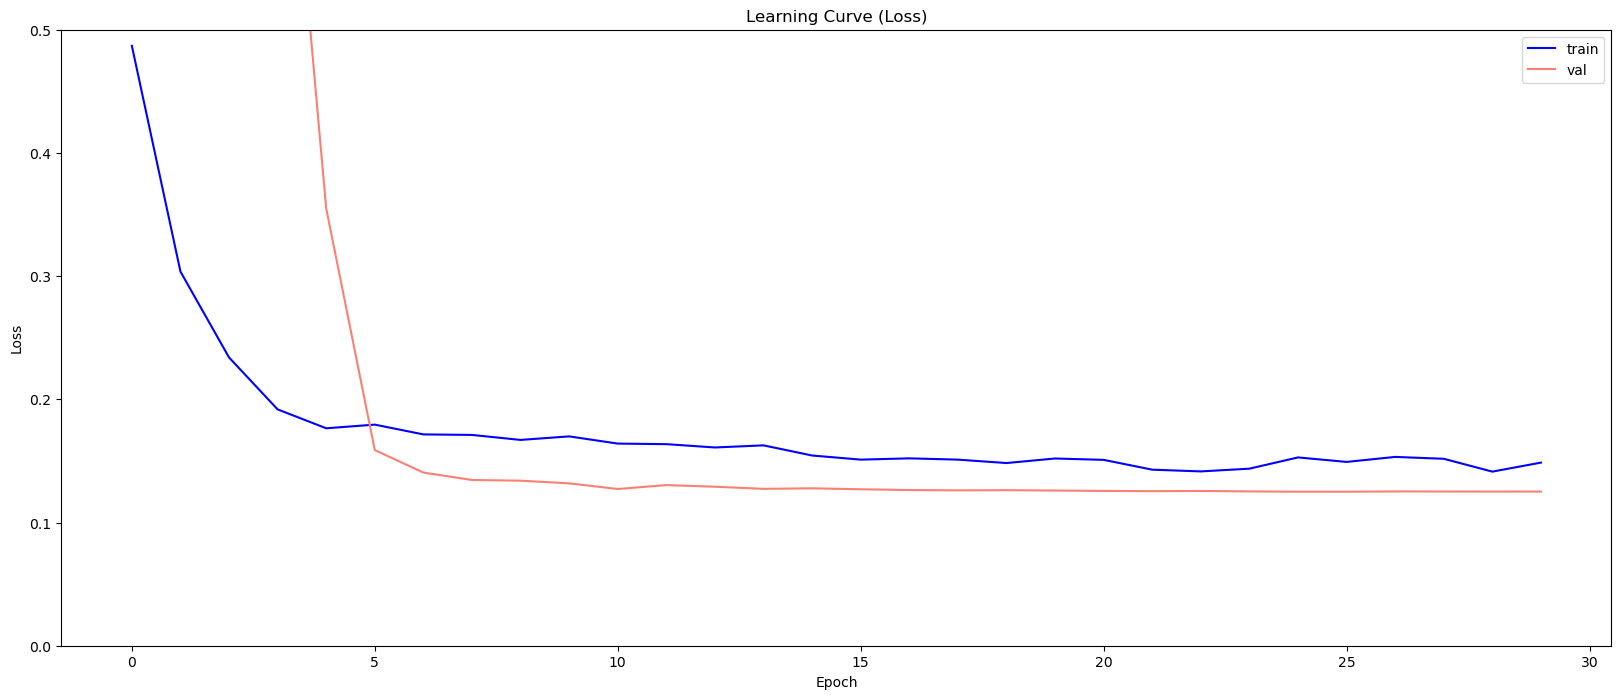

In [36]:
plot_learning_curve_loss(results2)

In [37]:
def plot_learning_curve_accuracy(history):
    # Set plot size
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Create line plots
    sns.lineplot(x=history.epoch, y=history.history['binary_accuracy'], color='blue')  # Plot training accuracy with blue color
    sns.lineplot(x=history.epoch, y=history.history['val_binary_accuracy'], color='salmon')  # Plot validation accuracy with salmon color
    
    # Set title, x-axis, and y-axis labels
    ax.set_title('Learning Curve (Accuracy)')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    
    # Set y-axis limit
    ax.set_ylim(0.80, 1.0)
    
    # Set colors for legend
    line1 = mat.lines.Line2D([], [], color='blue', label='train')  # Create a Line2D object for the train line with blue color
    line2 = mat.lines.Line2D([], [], color='salmon', label='val')  # Create a Line2D object for the val line with salmon color
    ax.legend(handles=[line1, line2], loc='best')  # Set the custom lines in the legend
    
    # Show the plot
    plt.show()

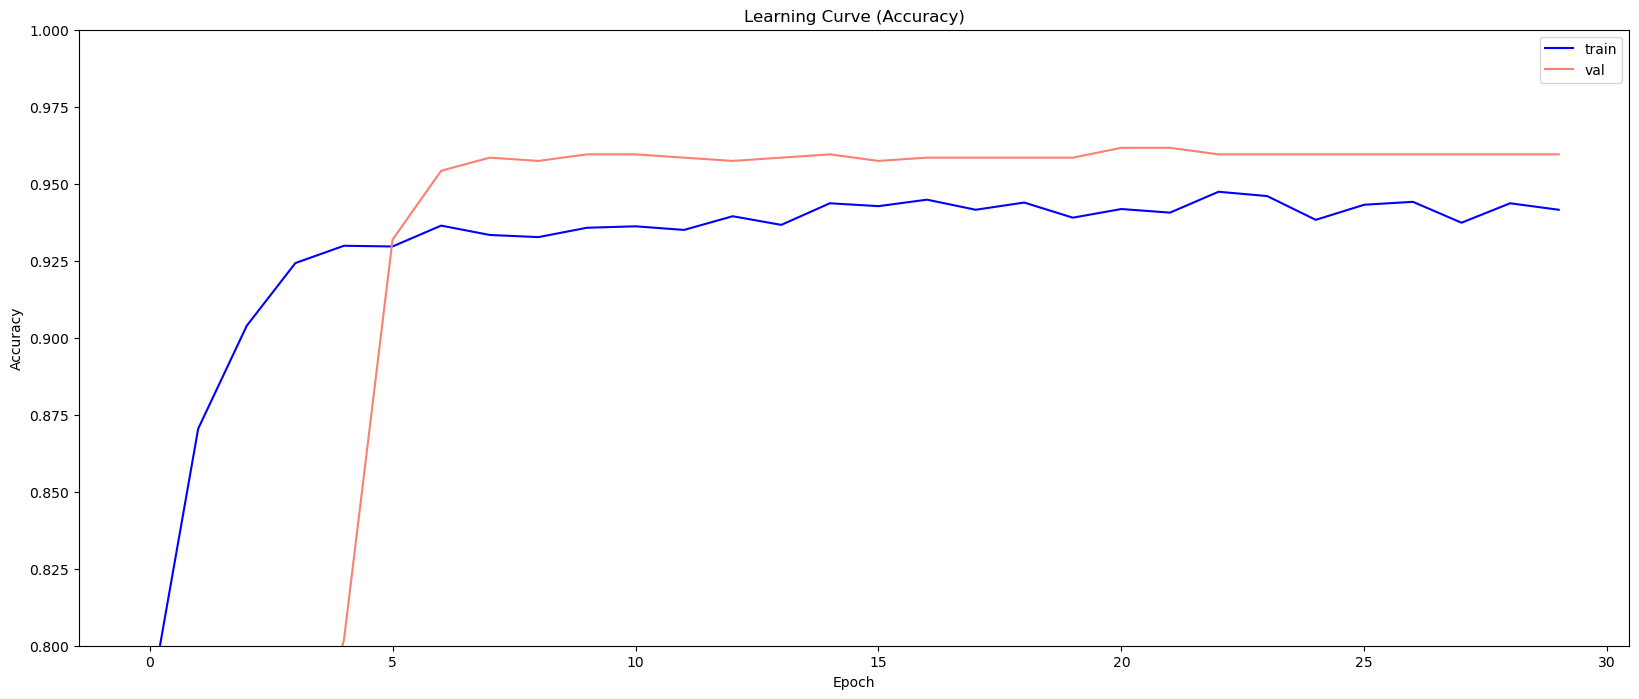

In [38]:
plot_learning_curve_accuracy(results2)

We see that our new model has done quite well on the training and validation set as both have accuracy in the high 90s, loss below .15, and almost no overfitting. Now let's test how are model did on our test set.

In [39]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn1_model.evaluate(ds_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

  4/624 [..............................] - ETA: 10s - loss: 0.5154 - binary_accuracy: 0.7500 

2023-07-03 15:05:44.208405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


624/624 [==============================] - 7s 10ms/step - loss: 0.5072 - binary_accuracy: 0.7949
Test Loss: 0.5072099566459656
Test Accuracy: 0.7948718070983887


In [40]:
# Get the predicted probabilities for the test set
test_predictions = cnn1_model.predict_generator(ds_test)

# Convert the predicted probabilities to binary predictions
test_predictions = (test_predictions > 0.5).astype(int)

# Get the ground truth labels for the test set
test_labels = ds_test.classes

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print(report)

2023-07-03 15:05:50.816120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.92      0.50      0.64       234
           1       0.76      0.97      0.86       390

    accuracy                           0.79       624
   macro avg       0.84      0.74      0.75       624
weighted avg       0.82      0.79      0.78       624



Although there is still a lot of overfitting; nonetheless, there is still a lot of improvement in our new model both in terms of loss, accuracy, as well as the fact that it doesn't predict every xray to have pneumonia. Let's move on and create a new model that will hopefully further improve the model on the testing set.

### Transfer Learning Model

We will now create a deeper neural network model using ResNet, which is a pretrained model inside `keras.application`. In general, during the backpropagation process of neural networkss, gradients move from the output layer to the input layer while changing the model's parameters. When the networks becomes deeper, the gradients can decrease or disappear as they pass through multiple layers. This can make it hard to train accurate yet deeper networks.

The ResNet model resolves this issue with a skip connection which creates an alternative and more direct path for gradient flow. As a result, the earlier layers can receive stronger gradient signals, leading to an improved training of the network.

Although we will have to set up some of the parameters overall the model takes an input image of size (224, 224, 3) and passes it through a convolutional layer with 64 filters of size (7, 7) and a stride of (2, 2). The model then has four stages which each consist of a sequence of convolutional layers, batch normalization, and activation functions. The key part of these stages is the skip connection. Then the model has a Global Average Pooling layer to reduce the dimensions to a vector of fixed length. This layer is connected to a fully connected layer which classifies based on the features. Finally the model has an ouput layer.

In [41]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

#create resnet model using ResNet152V2 from keras.applications
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',# Use pre-trained weights from ImageNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3),#input shape
    include_top=False)# Exclude top layers which is fully connected

#Only train the newly added layers while the pre_trained layers remain untrainable
base_model.trainable = False


def get_pretrained():
    
    #Input shape 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Connect input to the base model (ResNet152V2)
    x = base_model(inputs)

    # Apply global average pooling
    x = layers.GlobalAveragePooling2D()(x)
    # Add fully connected layer with 128 units and ReLU activation
    x = Dense(128, activation='relu')(x)
    # Apply dropout with rate of 0.1
    x = Dropout(0.1)(x)
    
    # Output layer with 1 unit and sigmoid activation
    output = Dense(1, activation='sigmoid')(x)
    # Create the model with specified inputs and outputs
    model = Model(inputs=[inputs], outputs=output)
    
    return model

In [42]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

# Clear the Keras session to release memory and resources
keras.backend.clear_session()

#create model
res_model = get_pretrained()

#Compile the model
res_model.compile(loss='binary_crossentropy', 
                         optimizer = optimizers.Adam(learning_rate=5e-5), 
                         metrics='binary_accuracy')
#print summary stats
res_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

With 262 thousand trainable parameters we see that our model now only has around 10% of the trainable parameters of the previous model. 

In [43]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)
         
# Train the model, using out set BATCH, and 50 epochs
results3 = res_model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,# Validate model with validation set
          callbacks=[early_stopping, plateau],#use early_stopping and plateau
          steps_per_epoch=(len(train_df)/BATCH),# Set steps per epoch by dividing training size by batch size
          validation_steps=(len(val_df)/BATCH));# Same for validation step size

Epoch 1/50


2023-07-03 15:06:01.866159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: 0s - loss: 0.3369 - binary_accuracy: 0.8681

2023-07-03 15:07:30.604914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 110s 790ms/step - loss: 0.3369 - binary_accuracy: 0.8681 - val_loss: 0.1902 - val_binary_accuracy: 0.9414 - lr: 5.0000e-05
Epoch 2/50
133/133 [==============================] - 141s 1s/step - loss: 0.1984 - binary_accuracy: 0.9266 - val_loss: 0.1400 - val_binary_accuracy: 0.9585 - lr: 5.0000e-05
Epoch 3/50
133/133 [==============================] - 98s 736ms/step - loss: 0.1553 - binary_accuracy: 0.9446 - val_loss: 0.1355 - val_binary_accuracy: 0.9521 - lr: 5.0000e-05
Epoch 4/50
133/133 [==============================] - 97s 725ms/step - loss: 0.1425 - binary_accuracy: 0.9476 - val_loss: 0.1113 - val_binary_accuracy: 0.9659 - lr: 5.0000e-05
Epoch 5/50
133/133 [==============================] - 97s 726ms/step - loss: 0.1293 - binary_accuracy: 0.9514 - val_loss: 0.1020 - val_binary_accuracy: 0.9659 - lr: 5.0000e-05
Epoch 6/50
133/133 [==============================] - 96s 722ms/step - loss: 0.1276 - binary_accuracy: 0.9567 - val_loss: 0.0908 - v

Let's pull up summary statistics to see how our model did on the training and validation set.

In [44]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

#evaluate the model on the validation set and pull up the loss and accuracy
score = res_model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

2023-07-03 15:39:20.547173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Val loss: 0.08070552349090576
Val accuracy: 0.9723109602928162


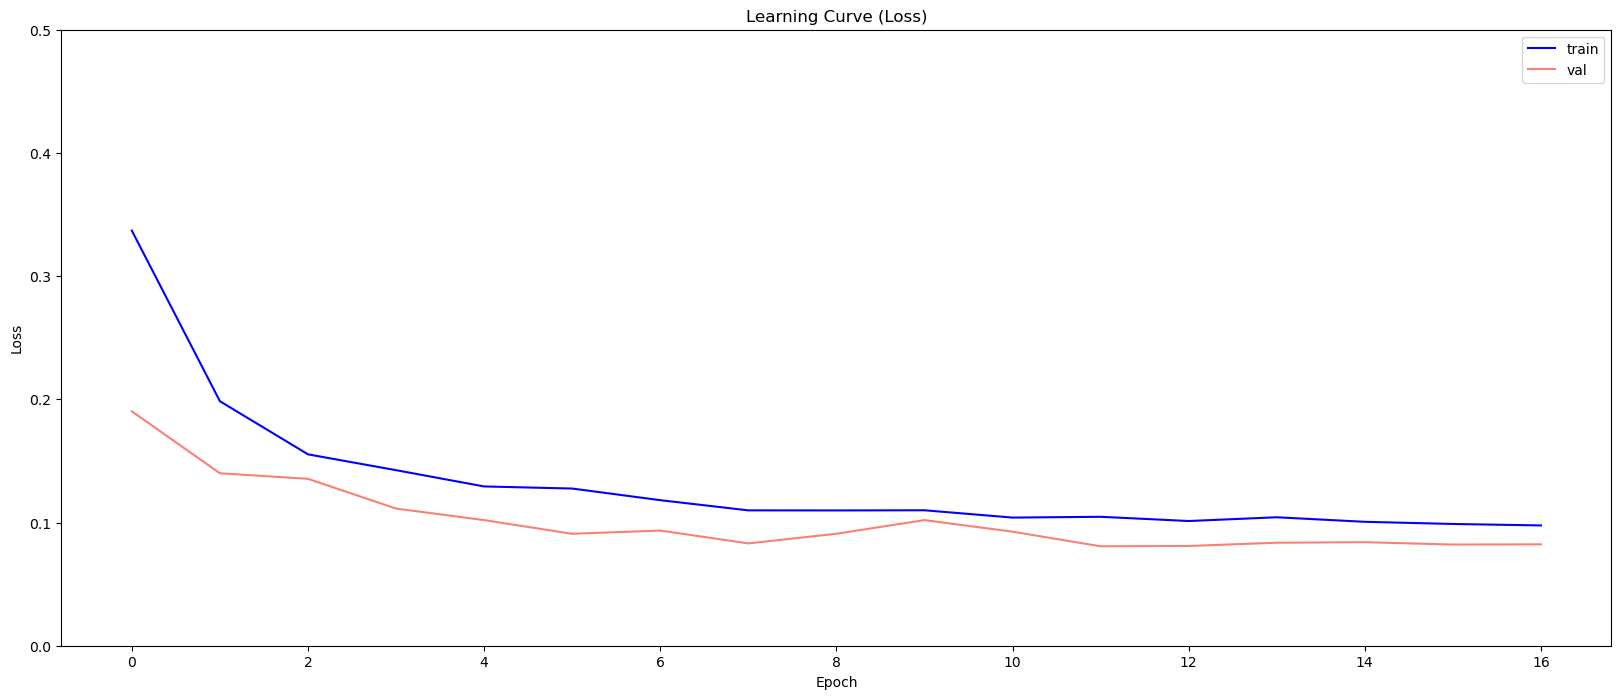

In [45]:
plot_learning_curve_loss(results3)

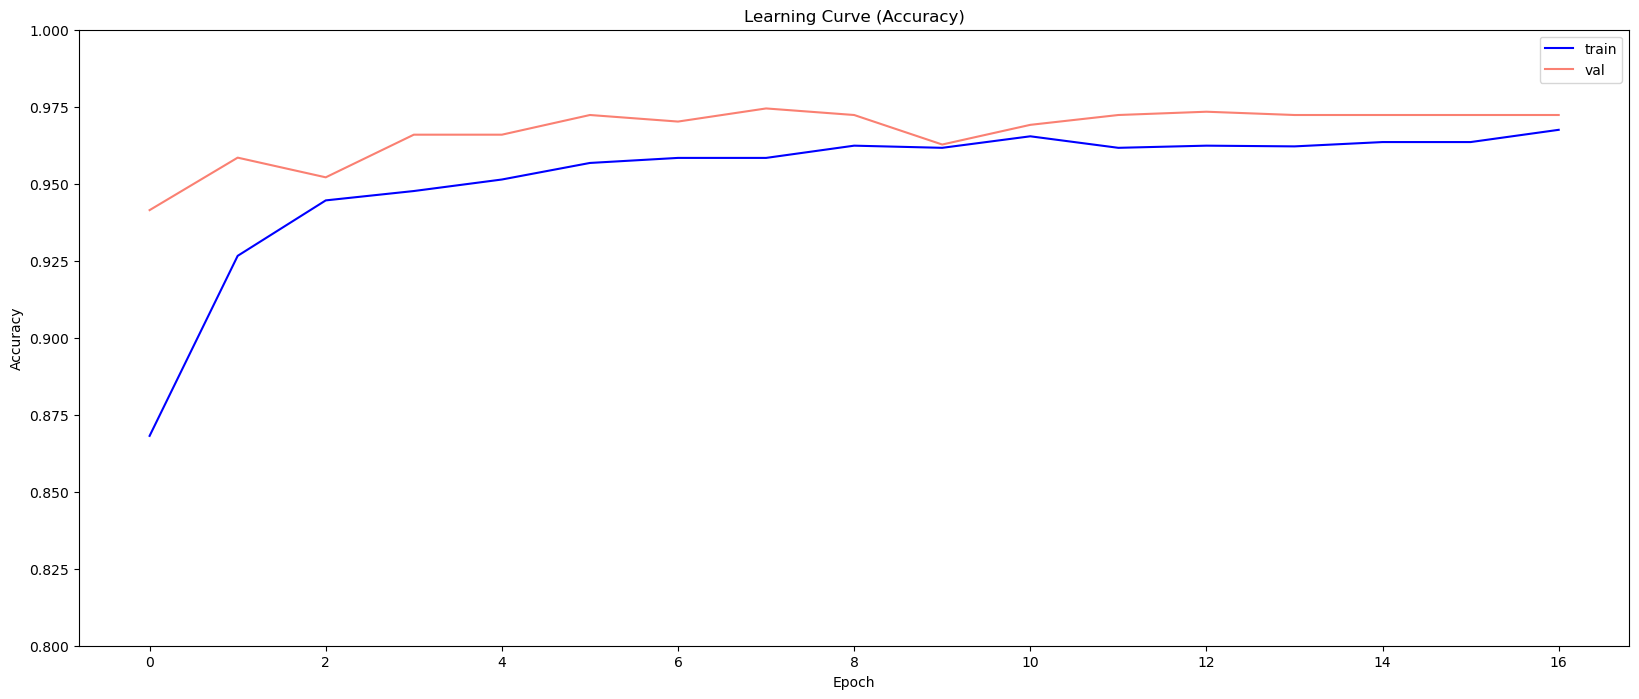

In [46]:
plot_learning_curve_accuracy(results3)

We see a further improvement in our model on the training and validation set, with accuracy very close to 100% and loss below .1.

Again we will test our model on the testing set to see how it does on unseen data, with a different proportion of xrays with pneumonia

In [47]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

#evaluate the model on testing set, and print the loss and accuracy
score = res_model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2023-07-03 15:39:41.041226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.4102446138858795
Test accuracy: 0.8525640964508057


In [48]:
# Get the predicted probabilities for the test set
test_predictions = res_model.predict_generator(ds_test)

# Convert the predicted probabilities to binary predictions
test_predictions = (test_predictions > 0.5).astype(int)

# Get the ground truth labels for the test set
test_labels = ds_test.classes

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print(report)

2023-07-03 15:40:20.995893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.96      0.63      0.76       234
           1       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



We see that that the ResNet/skip connection model has clearly caused an improvement in our model. The model's loss has decreased by around .1 and the accuracy has gone up by around 5%. However, more importantly the f1 score has increased by .03, as well as the recall by .01. Now, let's try tuning the model to see if we can further improve the metrics.


### Tuning 

In our previous model we froze all the layers in the base model, and only allowed the newly added layers to be trainable, this resulted in far less parameters than our first cnn model. Now, we will unfreeze the last 13 layers of our base model. We saw that the last model overall had almost 60 million overall parameters. If we unfreeze all of them, the model will be far to large, and not practical. As such we will only unfreeze the last layers as these are the most specified layers. This will increase the number of trainable paramets in our model, and improve it's statistics, without allowing the model to become too large.

In [49]:
#unfreeze all the layers
base_model.trainable = True

# Freeze all layers except for the last 13
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [50]:
# Check that only the last 13 layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [51]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

#compile the model
res_model.compile(loss='binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=2e-6), 
                  metrics='binary_accuracy')
#print summary stats
res_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

We now see that our model is almost double the size of our first cnn model, as it now has almost 5 million trainable parameters

In [52]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

# Train the model, using out set BATCH, and 50 epochs
results4 = res_model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,# Validate model with validation set
          callbacks=[early_stopping, plateau],#use early_stopping and plateau
          steps_per_epoch=(len(train_df)/BATCH),# Set steps per epoch by dividing training size by batch size
          validation_steps=(len(val_df)/BATCH));# Same for validation step size

Epoch 1/50


2023-07-03 15:40:59.480762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/133 [==============================] - ETA: 0s - loss: 0.1834 - binary_accuracy: 0.9415

2023-07-03 15:42:32.906810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 [==============================] - 117s 841ms/step - loss: 0.1834 - binary_accuracy: 0.9415 - val_loss: 0.1504 - val_binary_accuracy: 0.9638 - lr: 2.0000e-06
Epoch 2/50
133/133 [==============================] - 100s 744ms/step - loss: 0.1593 - binary_accuracy: 0.9523 - val_loss: 0.1320 - val_binary_accuracy: 0.9712 - lr: 2.0000e-06
Epoch 3/50
133/133 [==============================] - 101s 754ms/step - loss: 0.1512 - binary_accuracy: 0.9469 - val_loss: 0.1195 - val_binary_accuracy: 0.9702 - lr: 2.0000e-06
Epoch 4/50
133/133 [==============================] - 100s 752ms/step - loss: 0.1367 - binary_accuracy: 0.9572 - val_loss: 0.1102 - val_binary_accuracy: 0.9723 - lr: 2.0000e-06
Epoch 5/50
133/133 [==============================] - 100s 751ms/step - loss: 0.1295 - binary_accuracy: 0.9551 - val_loss: 0.1030 - val_binary_accuracy: 0.9744 - lr: 2.0000e-06
Epoch 6/50
133/133 [==============================] - 100s 745ms/step - loss: 0.1267 - binary_accuracy: 0.9574 - val_loss: 0.1

Again we will pull up summary statistics to see how the model did on the training and validation set

In [53]:
#evaluate the model on the val set and print loss and accuracy
score = res_model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.07470612972974777
Val accuracy: 0.9765708446502686


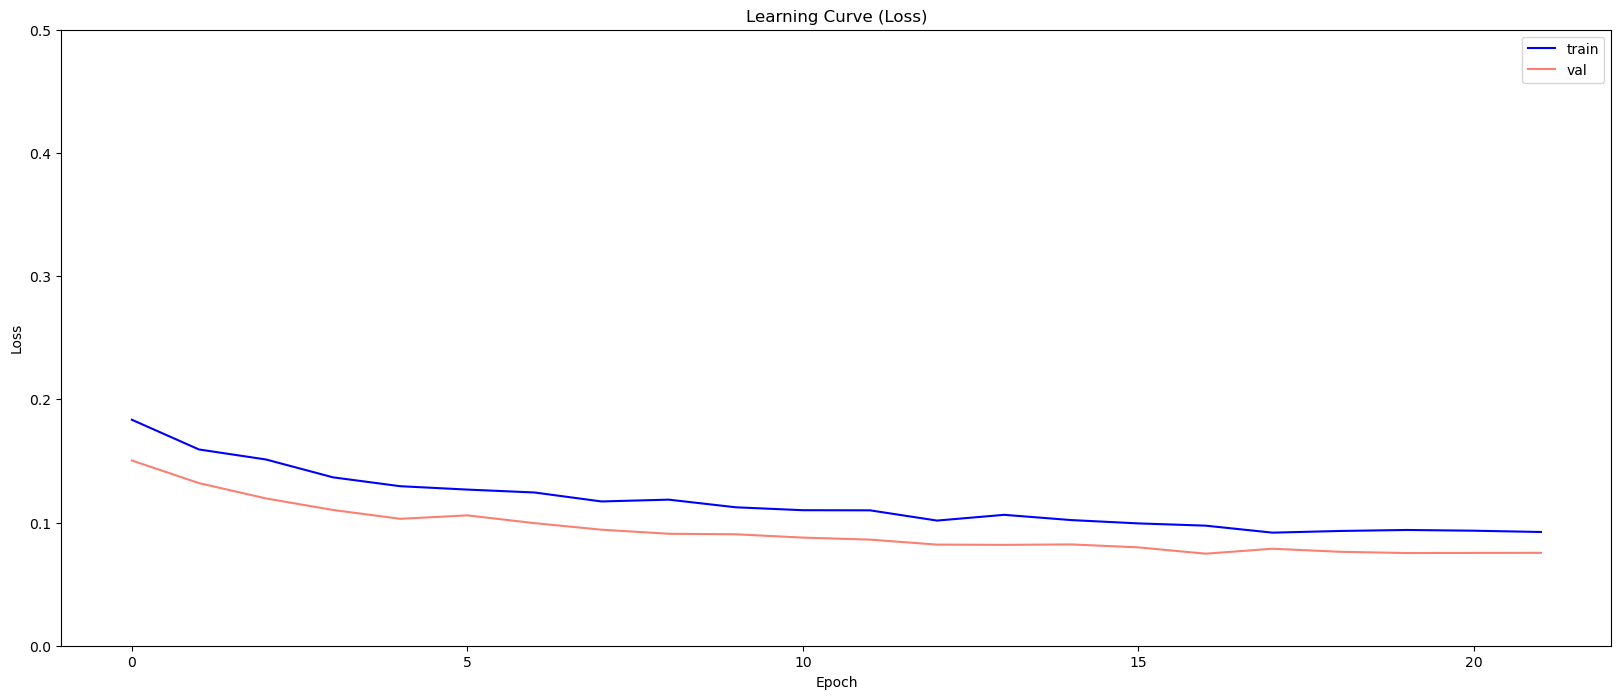

In [54]:
#plot the loss of train and val
plot_learning_curve_loss(results4)

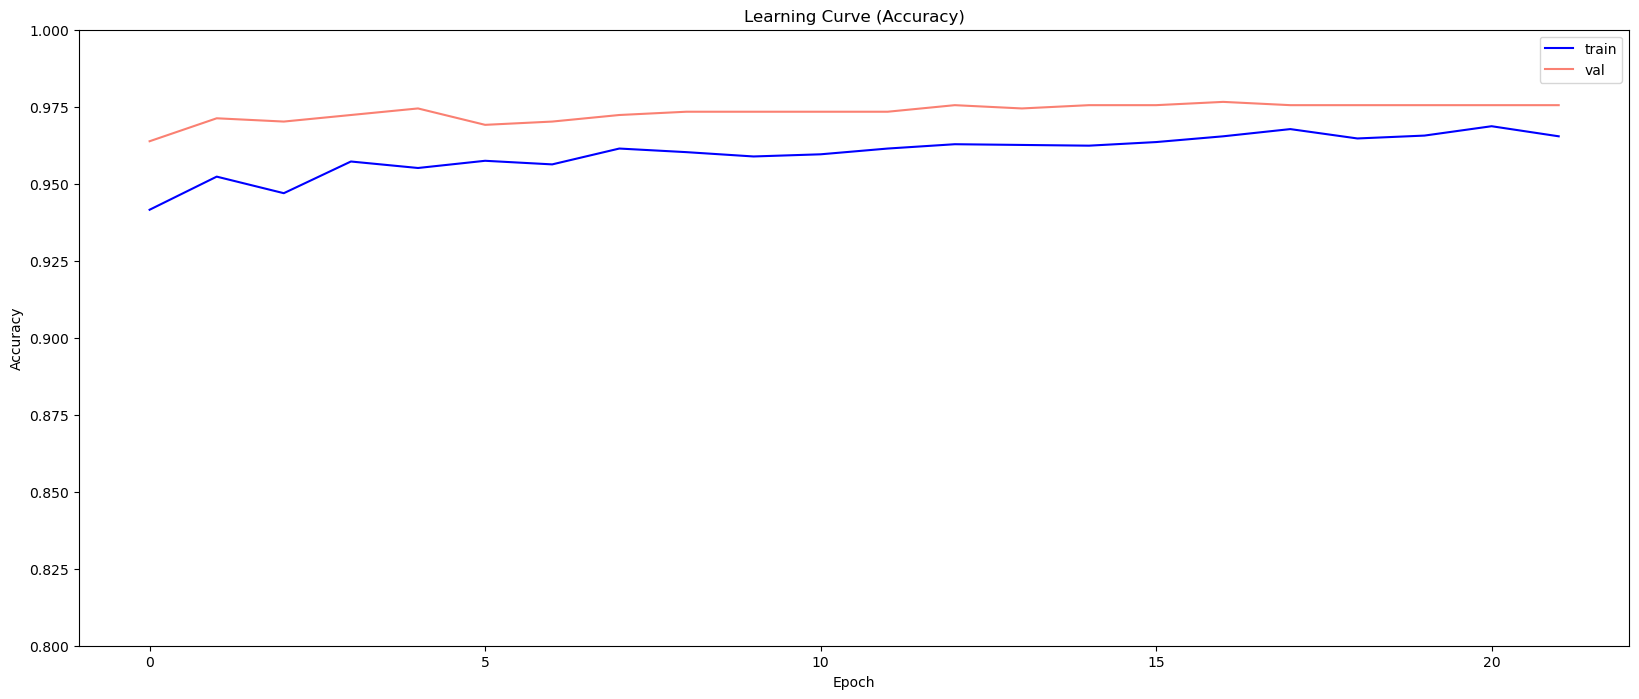

In [55]:
#plot the accuracy of train and val
plot_learning_curve_accuracy(results4)

Again, this model has further improved in terms of loss and accuracy on the validation set, with almost no overfitting.

Now, let's see how are model did on the testing set. Which again, is an unseen dataset with a slightly lower proportion of xrays with pneumonia.

In [56]:
#set seed
tf.random.set_seed(42)
np.random.seed(42)

#evaluate the model on the test set and print loss and accuracy
score = res_model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2023-07-03 16:18:30.077328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.3514775335788727
Test accuracy: 0.8605769276618958


Now, we are doing even better on our testing set. We will stick with this as our final model. Now let's move on to summary metrics

## Final Model Evaluation
Now, that we have gotten our best statistics, let's take a deeper look into different performance metrics to see if our recall needs to be improved. Let's pull up a classification report and confusion matrix of our test set predictions.

In [57]:
# Set labels for Normal and Pneumonia xrays to be replaced by 0 and 1
num_label = {'Normal': 0, 'Pneumonia' : 1}

# Copy df_test and map the labels onto the df as int type
Y_test = df_test['class'].copy().map(num_label).astype('int')

# Reset test ds index
ds_test.reset()

# Make preds for the test ds, don't show the output
predictions = res_model.predict(ds_test, steps=len(ds_test), verbose=0)

# Set threshold to 0.5, and assign predictions
pred_labels = np.where(predictions > 0.5, 1, 0)

# Print classification report for test set
report = classification_report(Y_test, pred_labels, labels=[0, 1])
print(report)

2023-07-03 16:19:09.300645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.95      0.67      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.85       624



There are four main things to look at here. Firstly, and most importantly, we see that our recall is a whopping 98%. Which means that we are catching almost all the patients with pneumonia. The second thing to notice is the precision of 83%, although this isn't ideal, since there will be expert doctors checking the xrays, we don't need to be concerned that patients will get treatment when really they are healthy. These two scores are combined to give us an f1 score of .9 which is a strong score. Lastly, our accuracy score is 86% which isn't amazing, but for our specific example, it's not as important.
Now, let's pull up a confusion matrix to see the predictions on the testing set. 

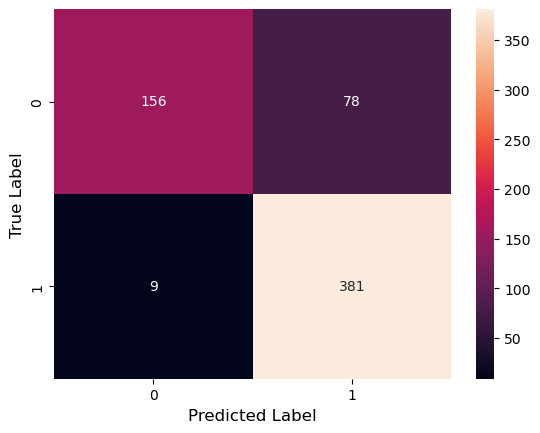

In [58]:
# Create confusion matrix using Y_test pred_labels
matrix = confusion_matrix(Y_test, pred_labels)

# Create heatmap of confusion matrix with annotations
sns.heatmap(matrix, annot=True, fmt="d")

# Set x and y labels
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Display the plot
plt.show()

We see that out of the 624 patients in the testing data set there was 390(10+380) patients who had pneumonia. The model correctly predicted the pneumonia status of 540 patients, this gives us the accuracy score we saw above of 87%. The model correctly captured 380 of the 390 patients who had pneumonia, giving us the recall score of 97%. The model incorrectly predicted that 74 patients had pneumonia, which gave us a precision score of 84%. The recall and precision scores were combined to give us an f1 score of .9

ROC_AUC:  0.9566951566951567


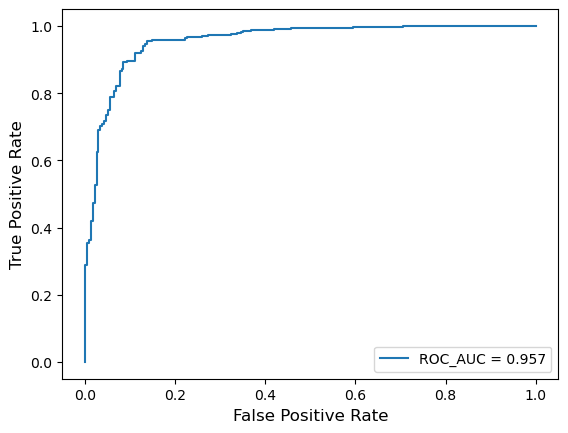

In [59]:
#create ROC curve using Y_test and predictictions
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

#set fpr, tpr and thresholds
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

#plot fpr, tpr with label
plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

#set x and y labels and create legend
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

#display plot
plt.show()

With an ROC score of .96 we see that we have a very strong model.

## LIME Evaluation
Unfortunately a problem may arise, we our model is not truly predicting the xrays based on the pneumonia or not but based on other things in the image. To solve this issue we will use LIME. 
LIME is a method that helps us understand why a machine learning model makes specific predictions. It does this by looking at a single prediction and approximating how the model would behave if it only had access to a small portion of the data. LIME then provides explanations by showing which features were most important in influencing the model's decision. In simpler terms, LIME helps us see the important factors behind a model's prediction for a particular instance. First, we'll test it out on an image with Pneumonia, and then an image without. In both examples it'll show us the percent chance that it is a Pneumonia xray

In [75]:
url = 'https://raw.githubusercontent.com/joshuaedelstein15/Pneumonia_analysis/main/images/Pneumonia_train.jpg'

def read_and_transform_img(url):
    # Read the image 
    img = skimage.io.imread(url)
    
    # Resize the image to correct dimensions (224x224) with 3 color channels
    img = skimage.transform.resize(img, (224, 224, 3))
    
    # Convert the image to array
    img = image.img_to_array(img)
    
    # Expand the dimensions of the image to match the expected input shape (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)

    return img

# read and transform img
images = read_and_transform_img(url)

# make prediction using the res_model
preds = res_model.predict(images)

# get highest predicted probability
prediction = np.argmax(preds)

# Get the maximum prediction probability
pct = np.max(preds)

# Print the maximum prediction probability
print(pct)


1/1 [==============================] - 0s 78ms/step
0.99478203


We see that the model correctly predicted this patient to have Pneumonia with 99% certainty.

In [61]:
# Create an instance of LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Use LimeImageExplainer to explain prediction
explanation1 = explainer.explain_instance( 
    images[0].astype('double'), # take the image
    res_model.predict, # take the prediction function
    top_labels=2, # take only the top 2 predicted labels
    hide_color=0, #set color for hiding pixels
    num_samples=1000 #generate 100 samples
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


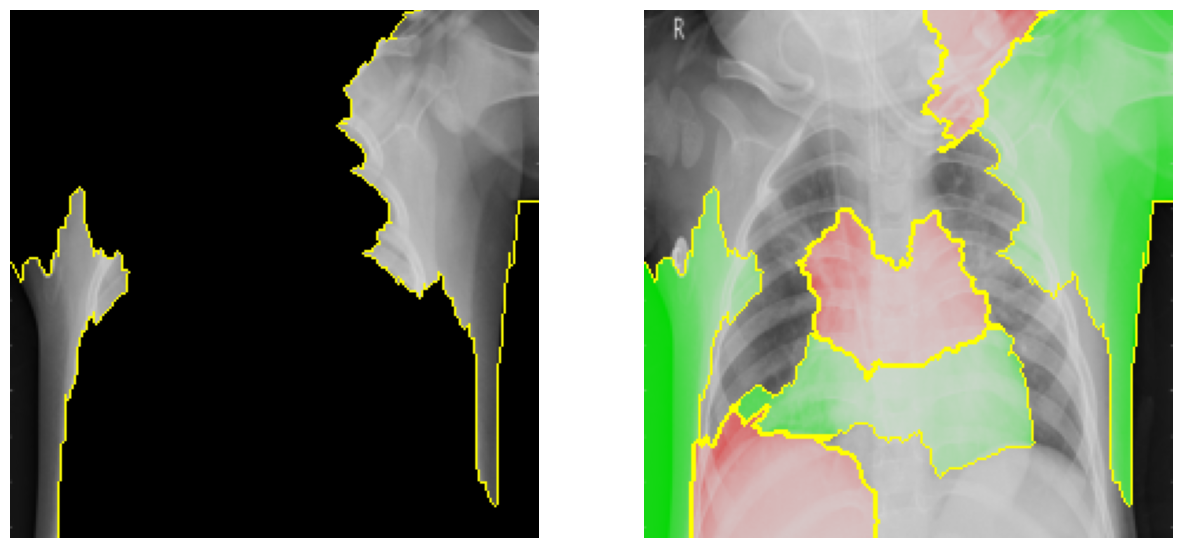

In [84]:
# Use explanation1 to get image and mask for the top pred label, show only + features
temp_1, mask_1 = explanation1.get_image_and_mask(
    explanation1.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# same as above showing both + and - features
temp_2, mask_2 = explanation1.get_image_and_mask(
    explanation1.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Show image with marked boundaries for + features in the first subplot
ax1.imshow(mark_boundaries(temp_1, mask_1))

# Show image with marked boundaries for both + and - features in the second subplot
ax2.imshow(mark_boundaries(temp_2, mask_2))

# Turn off the axes for both subplots
ax1.axis('off')
ax2.axis('off');

The areas showing in the axis on the left display the top 5 most important features that the model looks at. The area on the right displays the top 10 most important features, the green are the positive features(meaning it's more likely a patient has pneumonia), and the red is the negative. Based on the image on the left, it seems as though the most important features are not even in the chest cavity. Thus the top factors in this model are not looking at the right thing. However, this is not so alarming for a few reasons. We see from the image on the right, that areas in the chest cavity are still within the top 10 most important features, and thus are taken into consideration. Additionally, in our particular case we want the recall to be higher, so it is not an issue if the model slightly overpredicts pneumonia. This is especially since our model does take into account areas within the chest cavity within the top 10 most important features.

In [76]:
url = 'https://raw.githubusercontent.com/joshuaedelstein15/Pneumonia_analysis/main/images/Normal_train.jpg'

def read_and_transform_img(url):
    # Read the image 
    img = skimage.io.imread(url)
    
    # Resize the image to correct dimensions (224x224) with 3 color channels
    img = skimage.transform.resize(img, (224, 224, 3))
    
    # Convert the image to array
    img = image.img_to_array(img)
    
    # Expand the dimensions of the image to match the expected input shape (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)

    return img

# read and transform img
images = read_and_transform_img(url)

# make prediction using the res_model
preds = res_model.predict(images)

# get highest predicted probability
prediction = np.argmax(preds)

# Get the maximum prediction probability
pct = np.max(preds)

# Print the maximum prediction probability
print(pct)

1/1 [==============================] - 0s 65ms/step
0.0011180711


Being that this xray is a normal patient, this is a good sign.

In [64]:
# Create an instance of LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Use LimeImageExplainer to explain prediction
explanation2 = explainer.explain_instance( 
    images[0].astype('double'), # take the image
    res_model.predict, # take the prediction function
    top_labels=2, # take only the top 2 predicted labels
    hide_color=0, #set color for hiding pixels
    num_samples=1000 #generate 100 samples
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 66ms/step


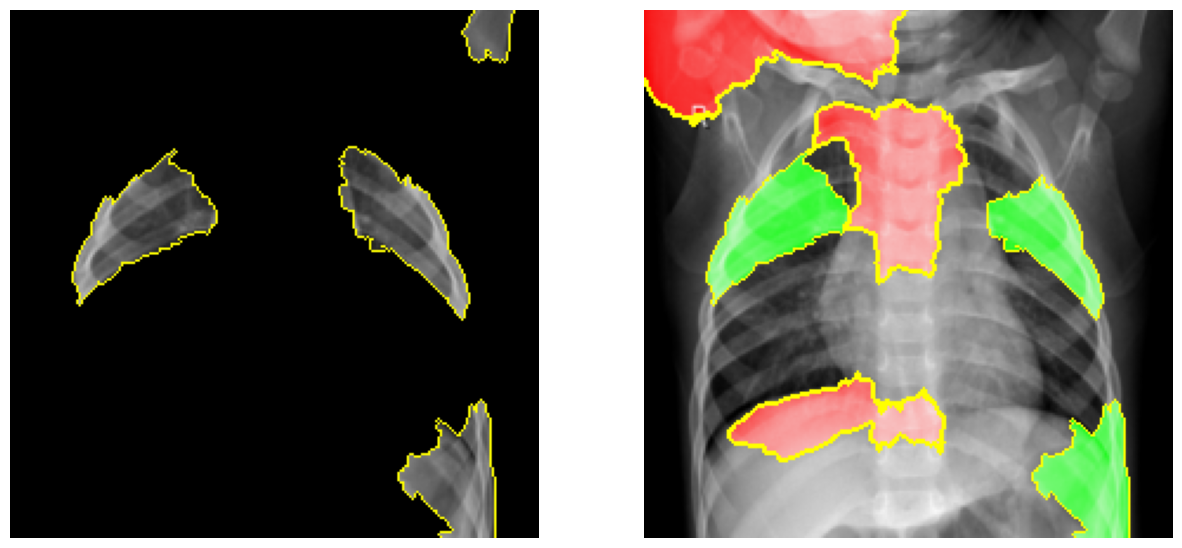

In [69]:
temp_1, mask_1 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off');

This is a good sign as most of the top factors are in the chest cavity.

## Conclusion
We will now sum up our findings from our analysis and modeling:

1. Model Type: Convolution Neural Network Transfer Learning model
- The specific model we used was a preloaded model from keras call ResNet, which is short for Residual Network. ResNet is a a type of convolutional neural network that uses a skip connection to create a more direct path for gradient flow during backpropagation. This allows the earlier layers to receive stronger gradient signals, leading to an improved training of the network. 
2. Model Scoring:
- F1-score of .9
- Recall of 98%
- Accuracy of 86%
- Precision of 83%
- Loss of .35
- ROC score of .96
3. Model Choice:
- We can see the tremendous improvement in all areas of our final model to our baseline model, as our baseline model just predicted every patient had pneumonia. 
- We saw a large improvement from our original cnn model which had a loss of .5, accuracy of 79%, recall of 98% and f1-score of .86. Our final model was far better with a loss of .34, accuracy of 86%, recall of 98%, and  f1-score of .90. Additionally, our final model had an exceptional ROC score of .96.

## Recommendations
We recommend that Dr. Xavier Radiance puts our model into effect immediately. This would lower the amount of xrays that would need to be checked by doctors, and allow Dr. Xavier to cut his costs. Additional recommendations would be to have doctors attempt to take a quick glance at the xrays that were normal, just to confirm, and attempt to catch the last 2 percent of people that slip through the model. 

## Limitations
The limitations on this model is that it was produced and testing on not such a large amount of data. In that around 5000 xrays in the overall dataset and 624 patients in the testing set is not very significant. Although it may take more time and resources, the model should be re trained with a larger dataset to improve it's validity.

## Next Steps
Moving forward we will offer a few possible steps to Dr. Radiance:

- Collect more data to create a more significant model. 
- Create a new model identifies whether the pneumonia is bacterial or viral. 
- Collect data on antibiotical treatments and analyze which are the most effective, and predict an outcome in each case.


### References
- https://www.kaggle.com/code/jonaspalucibarbosa/chest-x-ray-pneumonia-cnn-transfer-learning
- https://www.kaggle.com/code/pujithagrandhi/classification-of-pneumonia-using-cnn
- https://www.kaggle.com/code/bennyfung/pneumonia-two-stages-vgg16-densenet-inception-86